In [12]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T124541Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D65a278c414dc84c9710912c3d903a5a650356bb95a9b704b2b668f7066f3869867574eaa613519d5a048f6383fefd184a071e42e22f11c67e8bd19579043918aa0d185253100bf48aa99641149d1edf105a93c1f3824b4d13126aba64685680dad786e3c8b5d16081ad2b5a24258c9b8f260e9c860bcc3ecb3088284c62eee9da01938a7ae2330b279c8e3a1ccc1d379bbec518c0bfa7b27df980523eb7b19603008f765f10a0134581077efaa3cee119cc827d6fa0384e605b5dfcda912fd939510cdd626b9a64fff9c43b89004c8c3f18c9cb03369e63922aac939d5723027230d907a1ae01705937d74fa94fd7e1886a49926278942a8625182b8730ec457,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T124541Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D951de6205e7d0636842dfb16637df5357c3b2dd91e5156cb52640b0338ab446cd90b1786e66d67eb3641a256acf822261aac14c6b8bd704b32686bbabd7ae6ea1214df69aa6a404f8d63baaefc12d944327bf1c2bd66244fefcb469df57859a3fb2508cb12d7b188ae0a4653a66d0eba9f39741b1c34d75d32260053aede17a45042caa33fd8a2639e88a4623cef1a0c385cb3abe7a465a17613a9cf96d7c9e13eaba331ac7e7536fd62435b636b917aabe14a5930f031c8fcfab46f2ec8de81912c559a1a5d83953d9e1c2ff3a231ab0808c1c865a666d33942b9d239979908c8826aded508d76e5768add80fabe3536b8309495fcc7af116e5f0e7b44cfd1b,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T124541Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1be58caa5d6b166a4f04af84a3f0d3b7cae482c437a1e49ed47b3da486b00513fc381acfcf303e5735ccaba226ee0e99fa7f40ef1c0952fdf7257d7b4ac357ac75a71ce24bd2f4052e63eb681c1f50558d6c9dfc8e2fb3bbefb3eb9d33a1170f457d62eb8405f1f4d54e68f670f457131285d5fcc13e327509fdbdc333561c69914fda80e14633d407e53aa6da554599d95e17cbe5a0898d47369e991e4966c4ac419ecb9f2384ae1f0433ec1085c4402476442bf5fb01c75aafa59c4ee81b9f8222f3b68798c999dcf395c010e25911e4ad70a41fd6af961b81f591c4068a28984df743f6ff1c5cd4353e8b067c12ff73a628372909f7230be4a7bdd60f4725,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240930%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240930T124541Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dcc49150181f3b738079e7a499078934f5ab8369214026ebd90eb67811bc1e3bc468e58d1417d3d89761466ccd1ee05a800249ed4193fac5ec475b59f65d3bd92c6034faaec8cbd9b9b63d97a4ad930f0c362fc6630b34d11d77f73417f576cae6cd3af5058ff4cdb1c27faf0392159087cca833d3bf77eb21a5ce89c171a9f60630beff856cfca13b7eca494fee10db8651cb9dd7e50a5eb506fd6af0bf8342e14d8932ebbc5b71e9aef7baf8dbe8965bf9f13a990d82b8759f8847f217e8460c1b226b66522abb5f227b6a7e8fa175c17e55fa0a9067292c11875a0870be0ea4cca1617e176acf8f66cc4c7bda03427e6cf4124be0305a028fe6165b526d165'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
Data source import complete.


#  <center> Speech Emotion Recognition <center>

### I am going to build a speech emotion detection classifier.
### But first we need to learn about what is speech recognition (SER) and why are we building this project? Well, few of the reasons are-

#### First, lets define SER i.e. Speech Emotion Recognition.
* Speech Emotion Recognition, abbreviated as SER, is the act of attempting to recognize human emotion and affective states from speech. This is capitalizing on the fact that voice often reflects underlying emotion through tone and pitch. This is also the phenomenon that animals like dogs and horses employ to be able to understand human emotion.

#### Why we need it?

1. Emotion recognition is the part of speech recognition which is gaining more popularity and need for it increases enormously. Although there are methods to recognize emotion using machine learning techniques, this project attempts to use deep learning to recognize the emotions from data.

2. SER(Speech Emotion Recognition) is used in call center for classifying calls according to emotions and can be used as the performance parameter for conversational analysis thus identifying the unsatisfied customer, customer satisfaction and so on.. for helping companies improving their services

3. It can also be used in-car board system based on information of the mental state of the driver can be provided to the system to initiate his/her safety preventing accidents to happen

#### Datasets used in this project

* Crowd-sourced Emotional Mutimodal Actors Dataset (Crema-D)
* Ryerson Audio-Visual Database of Emotional Speech and Song (Ravdess)
* Surrey Audio-Visual Expressed Emotion (Savee)
* Toronto emotional speech set (Tess)

# Importing Libraries

In [13]:
!apt-get update
!apt-get install -y libsndfile1

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Ign:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsndfile1 is already the newest version (1.0.31-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


In [14]:

import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import  to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Preparation
* As we are working with four different datasets, so i will be creating a dataframe storing all emotions of the data in dataframe with their paths.
* We will use this dataframe to extract features for our model training.

In [15]:
# Paths for data.
Ravdess = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"
Crema = "/kaggle/input/cremad/AudioWAV/"
Tess = "/kaggle/input/toronto-emotional-speech-set-tess/tess toronto emotional speech set data/TESS Toronto emotional speech set data/"
Savee = "/kaggle/input/surrey-audiovisual-expressed-emotion-savee/ALL/"

##  <center> 1. Ravdess Dataframe <center>
Here is the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4
This means the meta data for the audio file is:

* Video-only (02)
* Speech (01)
* Fearful (06)
* Normal intensity (01)
* Statement "dogs" (02)
* 1st Repetition (01)
* 12th Actor (12) - Female (as the actor ID number is even)

In [16]:
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

Emotions                                               Path
0      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
2  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
4  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...

## <center>2. Crema DataFrame</center>

In [17]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

Emotions                                               Path
0    angry  /kaggle/input/cremad/AudioWAV/1053_ITS_ANG_XX.wav
1  disgust  /kaggle/input/cremad/AudioWAV/1037_ITH_DIS_XX.wav
2     fear  /kaggle/input/cremad/AudioWAV/1032_IWW_FEA_XX.wav
3     fear  /kaggle/input/cremad/AudioWAV/1049_ITH_FEA_XX.wav
4    happy  /kaggle/input/cremad/AudioWAV/1080_IEO_HAP_LO.wav

##  <center> 3. TESS dataset <center>

In [18]:
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

Emotions                                               Path
0      sad  /kaggle/input/toronto-emotional-speech-set-tes...
1      sad  /kaggle/input/toronto-emotional-speech-set-tes...
2      sad  /kaggle/input/toronto-emotional-speech-set-tes...
3      sad  /kaggle/input/toronto-emotional-speech-set-tes...
4      sad  /kaggle/input/toronto-emotional-speech-set-tes...

##  <center> 4. CREMA-D dataset <center>
The audio files in this dataset are named in such a way that the prefix letters describes the emotion classes as follows:

* 'a' = 'anger'
* 'd' = 'disgust'
* 'f' = 'fear'
* 'h' = 'happiness'
* 'n' = 'neutral'
* 'sa' = 'sadness'
* 'su' = 'surprise'

In [19]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

Emotions                                               Path
0     angry  /kaggle/input/surrey-audiovisual-expressed-emo...
1  surprise  /kaggle/input/surrey-audiovisual-expressed-emo...
2   disgust  /kaggle/input/surrey-audiovisual-expressed-emo...
3     angry  /kaggle/input/surrey-audiovisual-expressed-emo...
4     happy  /kaggle/input/surrey-audiovisual-expressed-emo...

In [20]:
# creating Dataframe using all the 4 dataframes we created so far.
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

Emotions                                               Path
0      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
1     fear  /kaggle/input/ravdess-emotional-speech-audio/a...
2  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...
3      sad  /kaggle/input/ravdess-emotional-speech-audio/a...
4  disgust  /kaggle/input/ravdess-emotional-speech-audio/a...

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

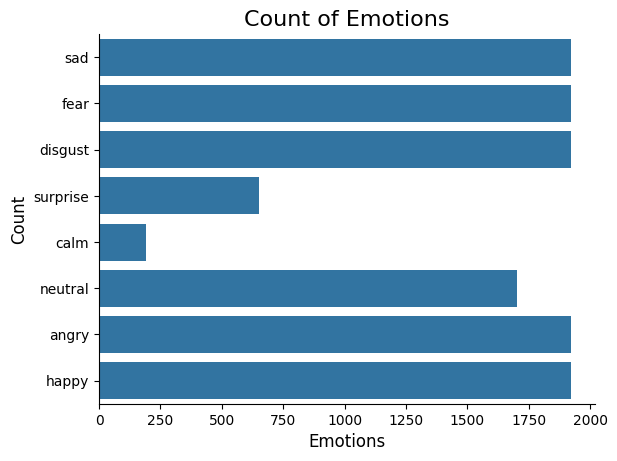

In [21]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [26]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

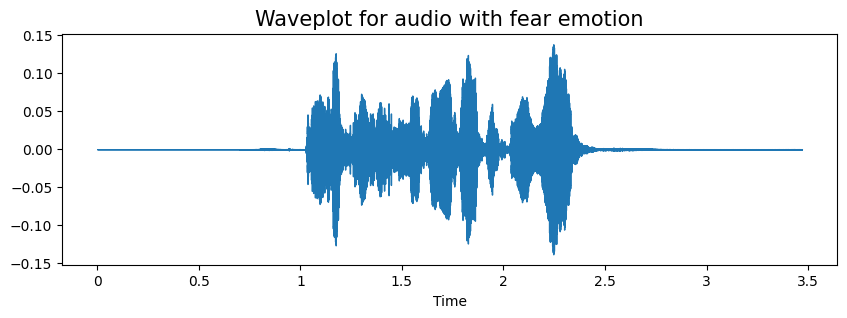

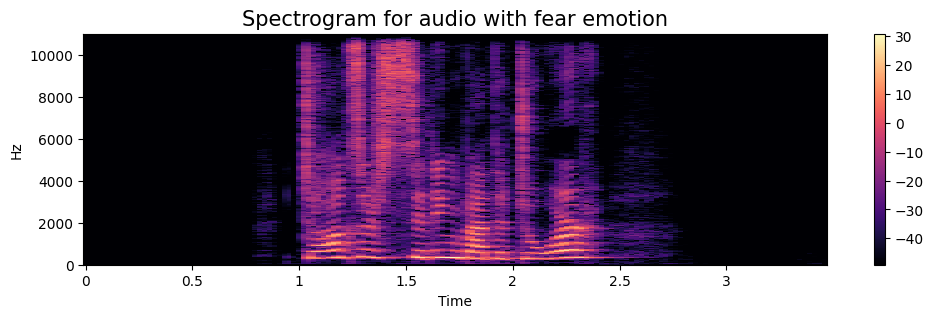

In [27]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

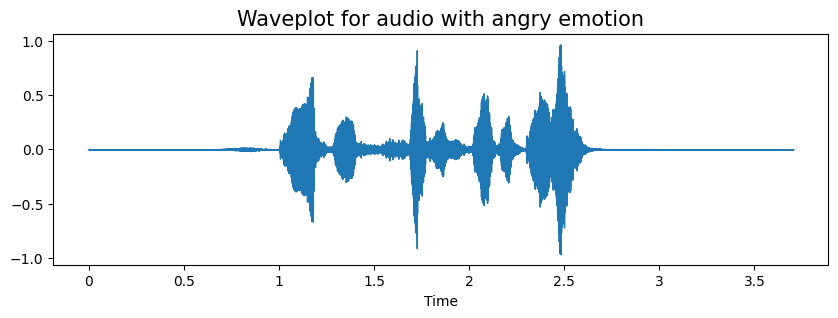

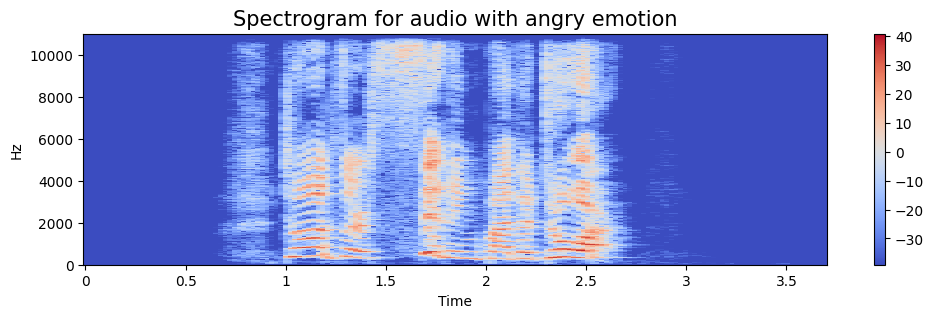

In [28]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

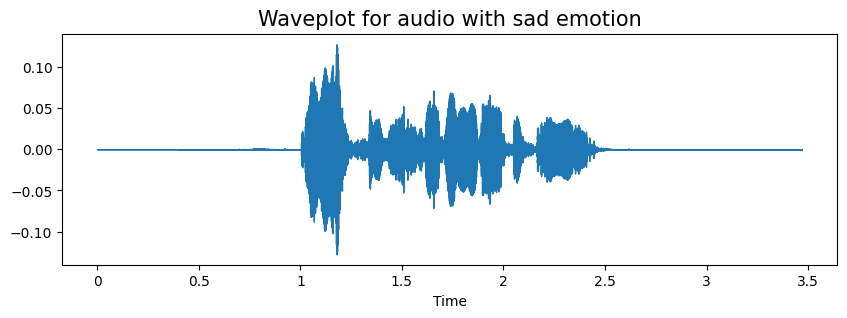

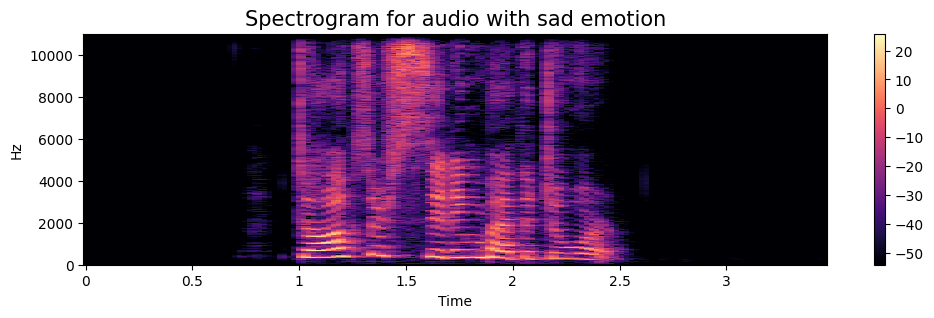

In [29]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

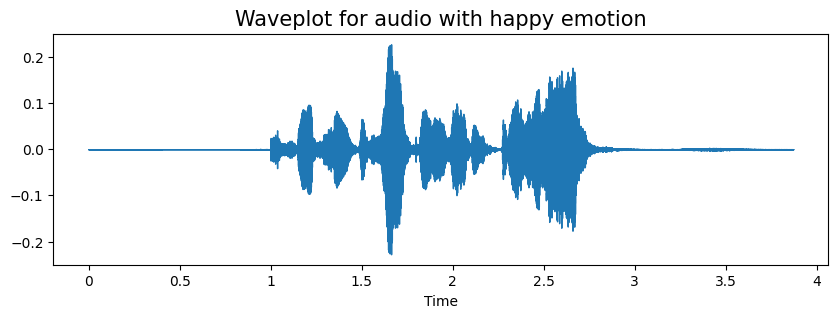

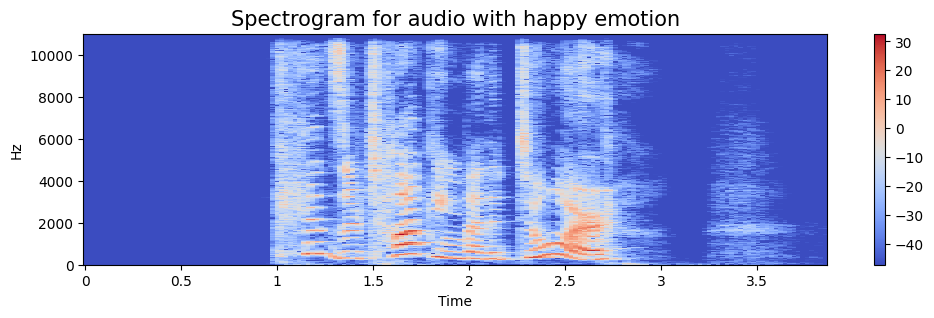

In [30]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.
- To generate syntactic data for audio, we can apply noise injection, shifting time, changing pitch and speed.
- The objective is to make our model invariant to those perturbations and enhace its ability to generalize.
- In order to this to work adding the perturbations must conserve the same label as the original training sample.
- In images data augmention can be performed by shifting the image, zooming, rotating ...

First, let's check which augmentation techniques works better for our dataset.

In [31]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr =sampling_rate,n_steps= pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

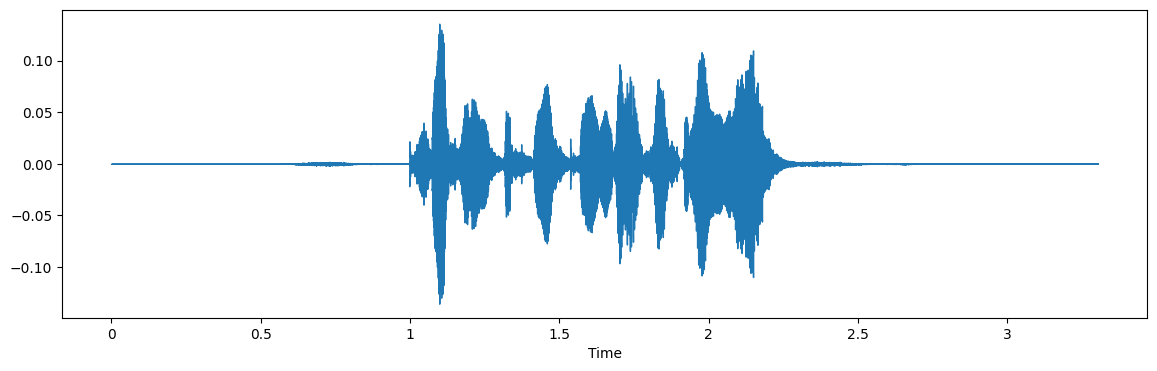

In [33]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

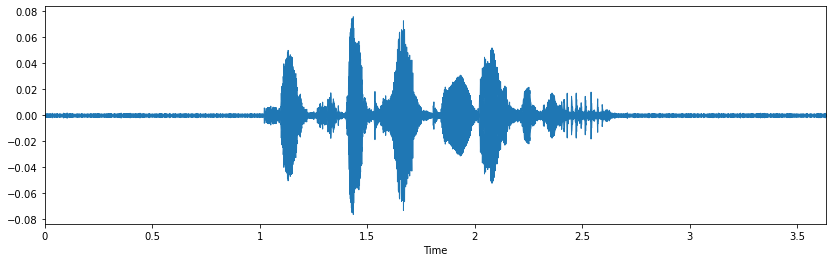

In [ ]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

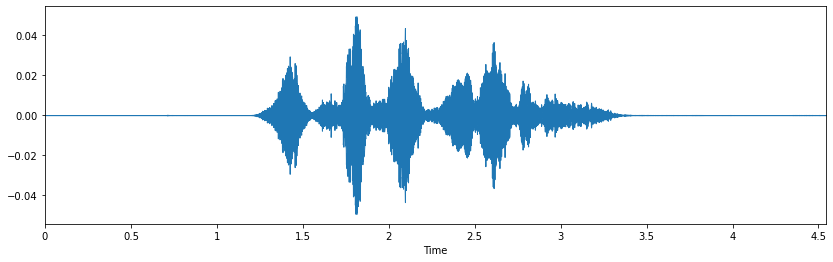

In [ ]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

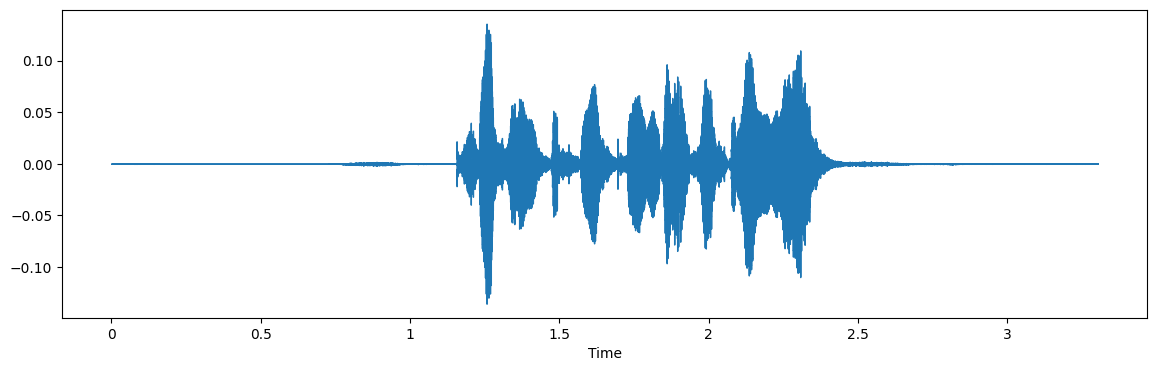

In [34]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

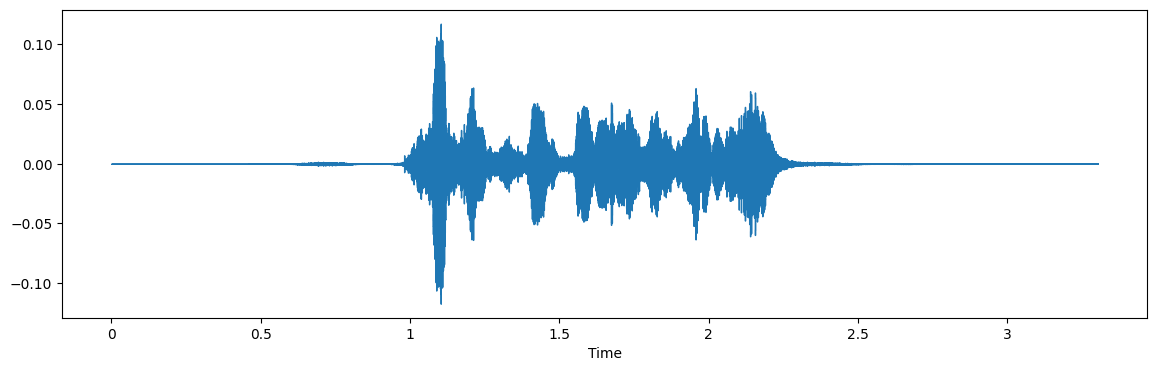

In [35]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.


The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

![image.png](https://miro.medium.com/max/633/1*7sKM9aECRmuoqTadCYVw9A.jpeg)

I am no expert on audio signals and feature extraction on audio files so i need to search and found a very good blog written by [Askash Mallik](https://medium.com/heuristics/audio-signal-feature-extraction-and-clustering-935319d2225) on feature extraction.

As stated there with the help of the sample rate and the sample data, one can perform several transformations on it to extract valuable features out of it.
1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy : The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy :  Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum is concentrated.
9.  MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency bands are not linear but distributed according to the mel-scale.
10. Chroma Vector : A 12-element representation of the spectral energy where the bins represent the 12 equal-tempered pitch classes of western-type music (semitone spacing).
11. Chroma Deviation : The standard deviation of the 12 chroma coefficients.


In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [36]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally

    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [37]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [38]:
len(X), len(Y), data_path.Path.shape

(36486, 36486, (12162,))

In [39]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features2.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.240691  0.629176  0.633081  0.614921  0.477467  0.410409  0.404236   
1  0.299520  0.676112  0.716429  0.715028  0.591356  0.547128  0.517077   
2  0.205273  0.616859  0.629304  0.613962  0.470300  0.361586  0.364944   
3  0.276399  0.610317  0.586033  0.576319  0.619141  0.703053  0.664605   
4  0.315317  0.705122  0.701926  0.692368  0.716044  0.774867  0.676091   

          7         8         9  ...       153       154       155       156  \
0  0.415035  0.450039  0.515831  ...  0.002715  0.002341  0.004225  0.005890   
1  0.472010  0.507464  0.542990  ...  0.007327  0.007745  0.009327  0.011108   
2  0.398812  0.466146  0.512885  ...  0.000756  0.000639  0.000550  0.000519   
3  0.647650  0.677573  0.650270  ...  0.000492  0.000439  0.000715  0.002114   
4  0.643829  0.662066  0.661635  ...  0.000612  0.000582  0.000825  0.002199   

        157       158       159       160       161  labels  
0  0.006079  0.006046  0.005886  0.002862  0.000231     sad  
1  0.010858  0.010678  0.011314  0.008094  0.005161     sad  
2  0.001155  0.001292  0.001085  0.000676  0.000045     sad  
3  0.001077  0.002796  0.002033  0.000311  0.000018    fear  
4  0.001218  0.002936  0.002155  0.000457  0.000147    fear  

[5 rows x 163 columns]

* We have applied data augmentation and extracted the features for each audio files and saved them.

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [40]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [41]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [42]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [43]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162), (27364, 8), (9122, 162), (9122, 8))

In [44]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27364, 162, 1), (27364, 8), (9122, 162, 1), (9122, 8))

## Modelling

In [9]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 256)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 21, 128)           0

In [10]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001) # this callback will decrease Lr with time till minimum
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
143/143 [==============================] - 6s 35ms/step - loss: 1.8560 - accuracy: 0.2457 - val_loss: 1.6009 - val_accuracy: 0.3456 - lr: 0.0010
Epoch 2/50
143/143 [==============================] - 5s 33ms/step - loss: 1.6380 - accuracy: 0.3302 - val_loss: 1.5485 - val_accuracy: 0.4262 - lr: 0.0010
Epoch 3/50
143/143 [==============================] - 4s 31ms/step - loss: 1.5322 - accuracy: 0.3837 - val_loss: 1.4061 - val_accuracy: 0.4568 - lr: 0.0010
Epoch 4/50
143/143 [==============================] - 5s 32ms/step - loss: 1.4634 - accuracy: 0.4148 - val_loss: 1.3445 - val_accuracy: 0.4811 - lr: 0.0010
Epoch 5/50
143/143 [==============================] - 5s 32ms/step - loss: 1.4208 - accuracy: 0.4333 - val_loss: 1.3126 - val_accuracy: 0.4854 - lr: 0.0010
Epoch 6/50
143/143 [==============================] - 4s 31ms/step - loss: 1.3662 - accuracy: 0.4504 - val_loss: 1.2628 - val_accuracy: 0.5067 - lr: 0.0010
Epoch 7/50
143/143 [==============================] - 4s 31ms/st

96/96 [==============================] - 1s 7ms/step - loss: 1.3453 - accuracy: 0.5672
Accuracy of our model on test data :  56.72476291656494 %


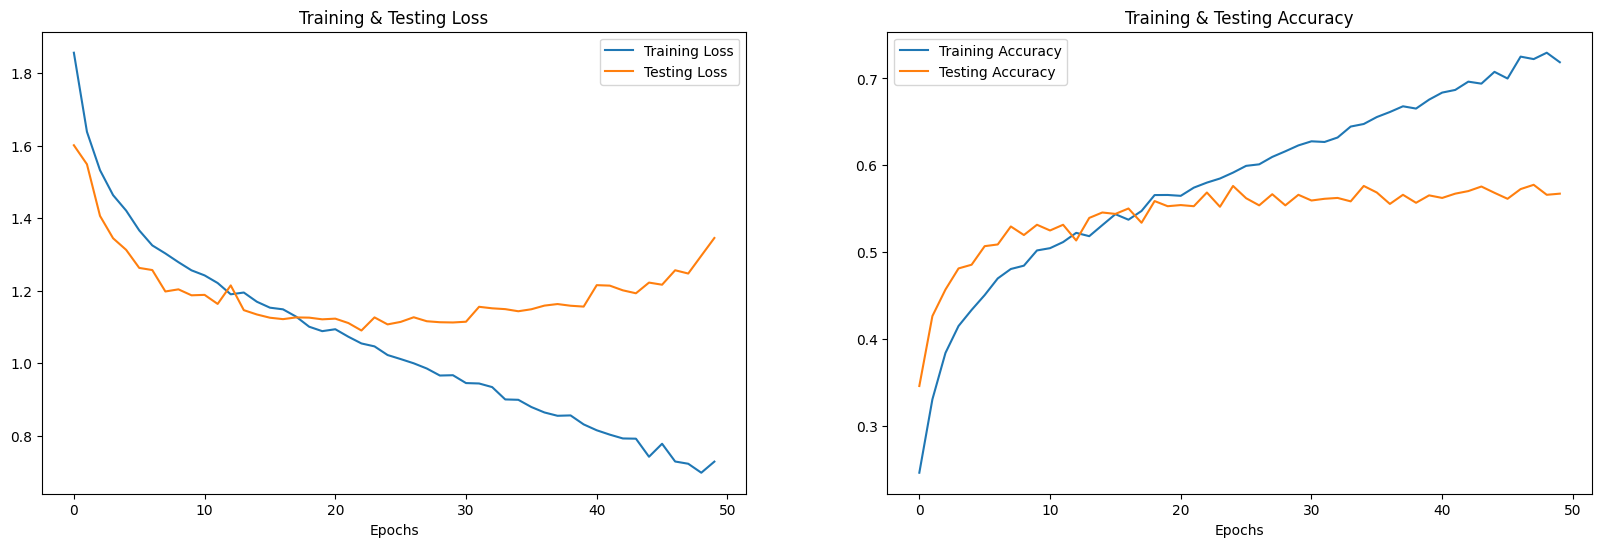

In [11]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

**Augmented_features_cnn**

In [45]:
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 162, 256)          1536      
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 81, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_5 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 41, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_6 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 21, 128)          

In [46]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)   # this callback will decrease Lr with time
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 15s 32ms/step - loss: 1.7014 - accuracy: 0.3072 - val_loss: 1.4649 - val_accuracy: 0.4102 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 13s 31ms/step - loss: 1.4574 - accuracy: 0.4157 - val_loss: 1.3191 - val_accuracy: 0.4769 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 13s 31ms/step - loss: 1.3640 - accuracy: 0.4518 - val_loss: 1.2644 - val_accuracy: 0.4945 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 13s 31ms/step - loss: 1.2986 - accuracy: 0.4809 - val_loss: 1.2144 - val_accuracy: 0.5087 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 13s 31ms/step - loss: 1.2523 - accuracy: 0.4983 - val_loss: 1.1947 - val_accuracy: 0.5259 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 13s 31ms/step - loss: 1.2231 - accuracy: 0.5093 - val_loss: 1.1950 - val_accuracy: 0.5207 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 13s 

286/286 [==============================] - 2s 7ms/step - loss: 1.0994 - accuracy: 0.6006
Accuracy of our model on test data :  60.0635826587677 %


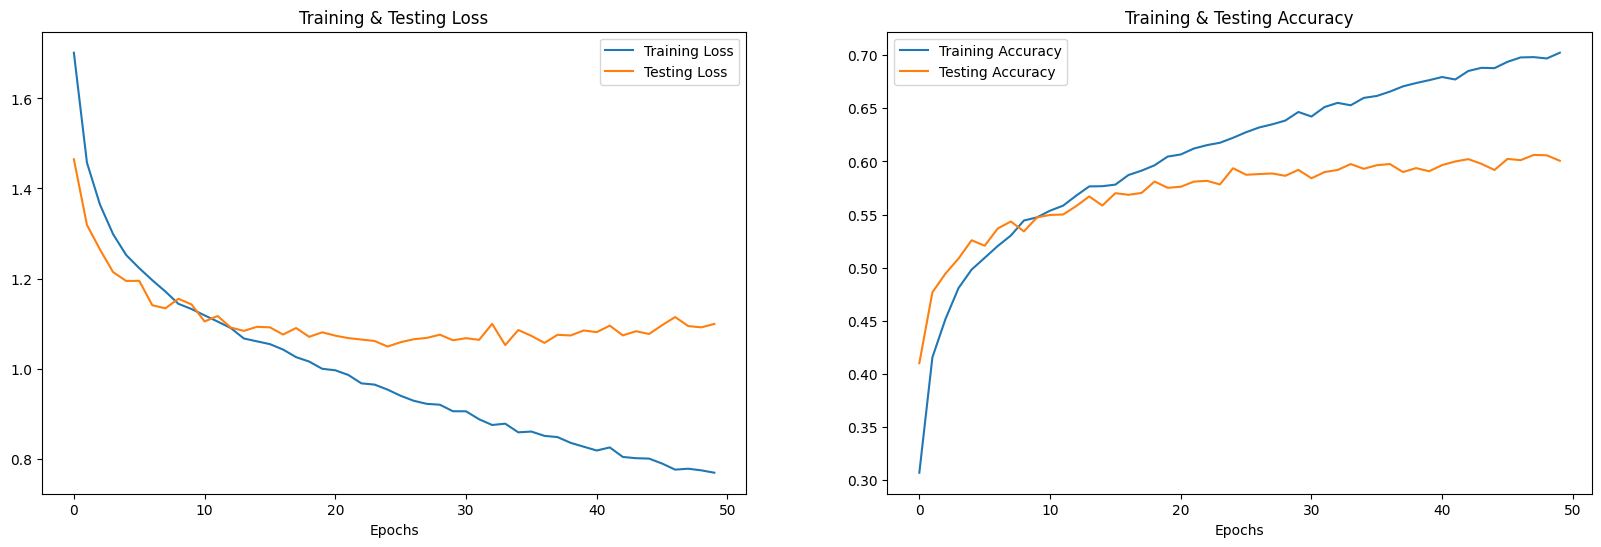

In [48]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

**Changed CNN **

In [51]:
import keras.layers as L

model = keras.Sequential([
    L.Conv1D(512,kernel_size=5, strides=1,padding='same', activation='relu',input_shape=(x_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),

    L.Conv1D(256,kernel_size=5,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(256,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    Dropout(0.2),

    L.Conv1D(128,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=3,strides=2,padding='same'),
    Dropout(0.2),

    L.Flatten(),
    L.Dense(256,activation='relu'),
    L.BatchNormalization(),
    L.Dense(8,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_13 (Conv1D)          (None, 162, 512)          3072      
                                                                 
 batch_normalization_6 (Bat  (None, 162, 512)          2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_13 (MaxPooli  (None, 81, 512)           0         
 ng1D)                                                           
                                                                 
 conv1d_14 (Conv1D)          (None, 81, 256)           655616    
                                                                 
 batch_normalization_7 (Bat  (None, 81, 256)           1024      
 chNormalization)                                                
                                                      

In [52]:
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 41s 88ms/step - loss: 1.5754 - accuracy: 0.4052 - val_loss: 2.6049 - val_accuracy: 0.2354 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 37s 87ms/step - loss: 1.3021 - accuracy: 0.4873 - val_loss: 2.2718 - val_accuracy: 0.2957 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 37s 88ms/step - loss: 1.2344 - accuracy: 0.5144 - val_loss: 1.5969 - val_accuracy: 0.4443 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 37s 86ms/step - loss: 1.1961 - accuracy: 0.5281 - val_loss: 1.2938 - val_accuracy: 0.4970 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 37s 87ms/step - loss: 1.1598 - accuracy: 0.5410 - val_loss: 1.2057 - val_accuracy: 0.4988 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 37s 86ms/step - loss: 1.1310 - accuracy: 0.5560 - val_loss: 1.2211 - val_accuracy: 0.5244 - lr: 0.0010
Epoch 7/50
428/428 [==============================] - 37s 

286/286 [==============================] - 4s 14ms/step - loss: 1.1082 - accuracy: 0.6790
Accuracy of our model on test data :  67.90177822113037 %


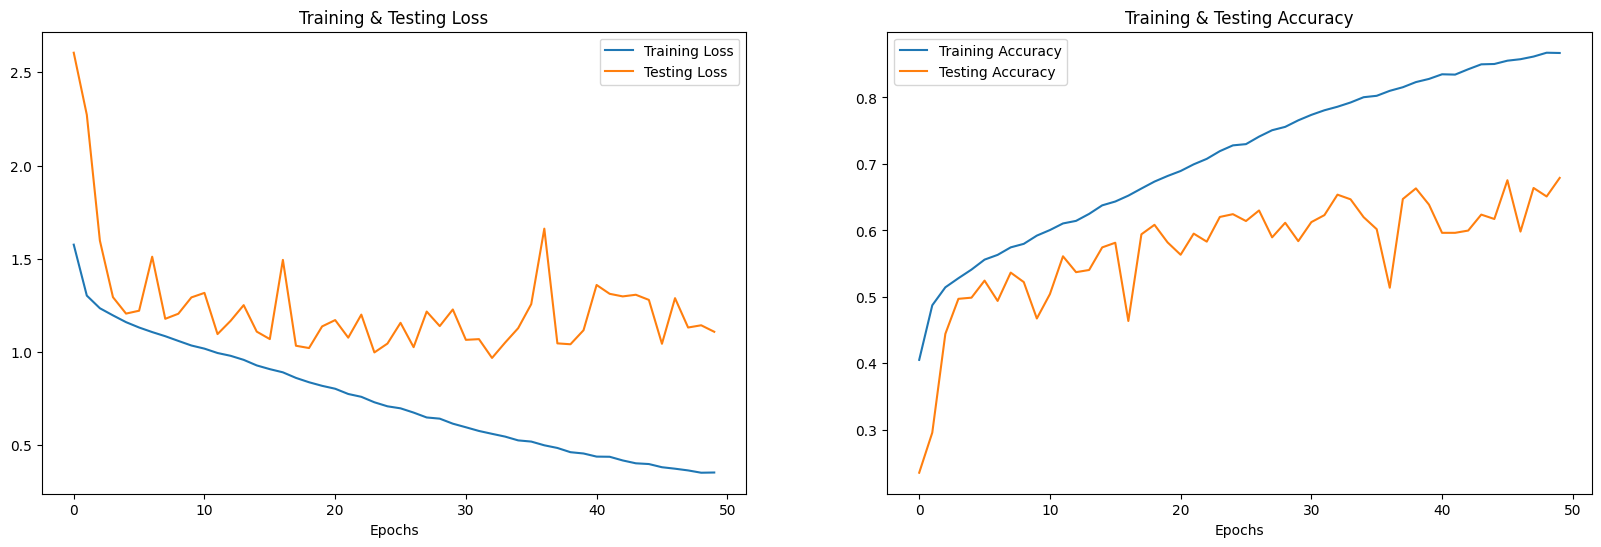

In [53]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

**Checking call back on validation loss**

In [55]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)   # this callback will decrease Lr with time, Tried on val_loss this time
history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
428/428 [==============================] - 36s 85ms/step - loss: 0.3385 - accuracy: 0.8735 - val_loss: 1.1576 - val_accuracy: 0.6796 - lr: 0.0010
Epoch 2/50
428/428 [==============================] - 36s 84ms/step - loss: 0.3295 - accuracy: 0.8765 - val_loss: 1.1373 - val_accuracy: 0.6776 - lr: 0.0010
Epoch 3/50
428/428 [==============================] - 36s 84ms/step - loss: 0.3217 - accuracy: 0.8790 - val_loss: 1.0814 - val_accuracy: 0.6849 - lr: 0.0010
Epoch 4/50
428/428 [==============================] - 36s 83ms/step - loss: 0.3114 - accuracy: 0.8841 - val_loss: 1.1543 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 5/50
428/428 [==============================] - 36s 84ms/step - loss: 0.3019 - accuracy: 0.8863 - val_loss: 1.2623 - val_accuracy: 0.6476 - lr: 0.0010
Epoch 6/50
428/428 [==============================] - 36s 84ms/step - loss: 0.2271 - accuracy: 0.9162 - val_loss: 1.0982 - val_accuracy: 0.7014 - lr: 4.0000e-04
Epoch 7/50
428/428 [==============================] - 

**After 20th epoch**
I realized there should be early stopping  😑

286/286 [==============================] - 4s 14ms/step - loss: 1.1463 - accuracy: 0.7092
Accuracy of our model on test data :  70.91646790504456 %


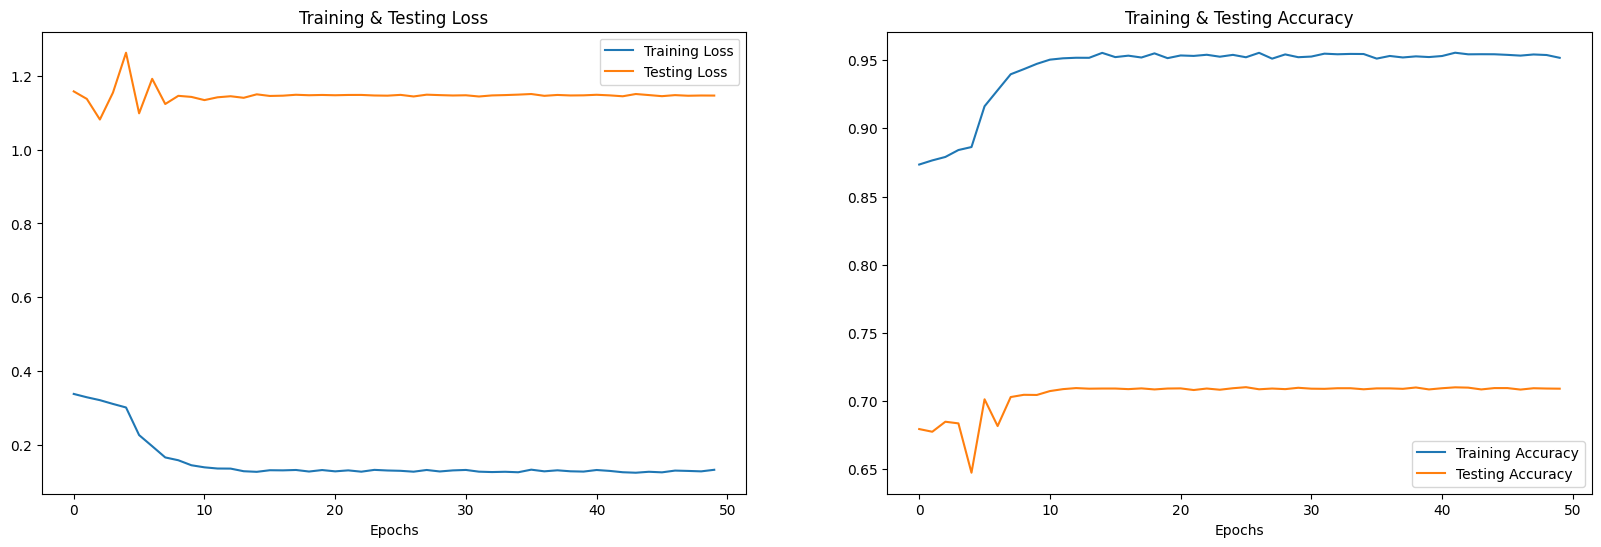

In [56]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

**Could not get what happened here**

In [ ]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [ ]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

- We can see our model is more accurate in predicting surprise, angry emotions and it makes sense also because audio files of these emotions differ to other audio files in a lot of ways like pitch, speed etc..
- We overall achieved 61% accuracy on our test data and its decent but we can improve it more by applying more augmentation techniques and using other feature extraction methods.

### This is all i wanna do in this project. Hope you guyz like this.
### If you like the kernel make sure to upvote it please :-)